# Clasificador paisajes
Para este ejercicio vas a crear un clasificador automático de paisajes. Los datos los encontrarás en el Clasroom como `seg_train.zip` y `seg_test.zip`. Se pide:
1. Cargar las imágenes. Mira cómo están almacenados los datos. Tendrás que recorrer las carpetas, cargar las imágenes en memoria y etiquetarlas con los nombres de las carpetas. Realiza un reshape de cada imagen (comienza el ejercicio con 32x32, para ir más rápido en las ejecuciones).
2. Investiga las imágenes, comprueba con algunas muestras que has cargado bien los datos.
3. Normaliza
4. Diseña la arquitectura de la red. Recuerda que es un algiritmo de clasificación. Ojo con las dimensiones de la entrada
5. Reserva un 20% de los datos del entrenamiento para validar.
6. Representa el objeto history
7. Evalua el modelo con los datos de test
8. Representa algunos de los paisajes donde el modelo comete errores
9. Crea una matriz de confusión con los errores del modelo

**NOTA apartado 1**: para el apartado 1 tendras que recorre las carpetas/imagenes con `os.listdir()`, e ir cargando todas las imagenes como arrays de numpy

**NOTA apartado 4**: empieza con un par de capas Conv2D + MaxPooling2D con activación relu y después la fully connected layer. on softmax como ultima capa

In [1]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (32, 32)

In [2]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm

In [3]:
def load_data():
    
    datasets = ['./seg_train',
                './seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder. tqdm is a widget in output...
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

  3%|▎         | 56/2191 [00:00<00:03, 559.45it/s]

Loading ./seg_train


 15%|█▌        | 67/437 [00:00<00:00, 664.06it/s]

Loading ./seg_test


100%|██████████| 501/501 [00:00<00:00, 766.34it/s]


In [5]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training examples: {}".format(n_train))
print("Number of testing examples: {}".format(n_test))
print("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (32, 32)


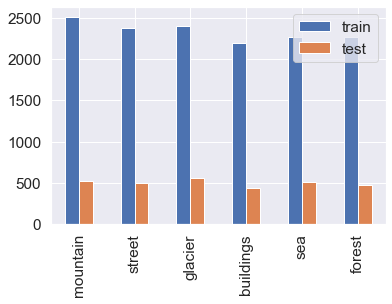

In [6]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_,test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
             'test': test_counts},
            index = class_names).plot.bar()

Text(0.5, 1.0, 'Proportion of each observed category')

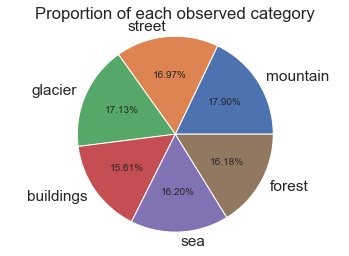

In [22]:
plt.pie(train_counts,
       explode = (0, 0, 0, 0, 0, 0),
       labels = class_names,
       autopct='%1.2f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
        

In [23]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [24]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label
        from the labels array
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    

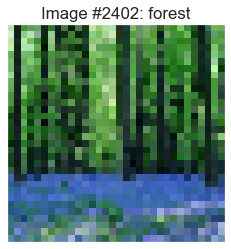

In [25]:
display_random_image(class_names, train_images, train_labels)

In [26]:
# las primeras 25 imágenes

def display_examples(class_names, images, labels):
    """
    Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    

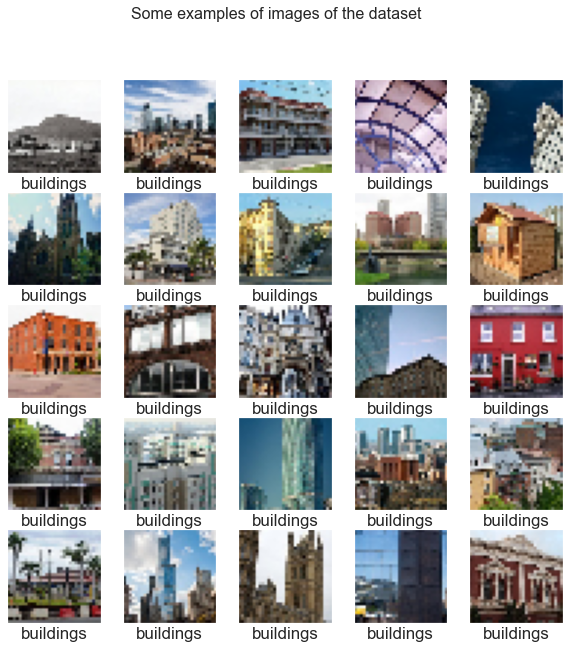

In [27]:
display_examples(class_names, train_images, train_labels)

In [28]:
# 1. Vamos a crear el modelo
# 2. Compilamos el modelo
# 3. Train/fit los datos en el modelo
# 4. Evaluamos el modelo con el test
# 5. Hacemos un análisis de los errores

In [29]:
# Construimos un modelo sencillo compuesto de:
# * Conv2D: (32 filtros de 3x3)
# * MaxPooling2D (las imágenes se quedan en la mitad del tamaño)
# * Flatten: transformamos el formato de 2D a 1D con 150 150 3 valores de los píxels
# * Relu: dado un valor x, devuelve max(x,0)
# * Softmax: 6 neuronas, es la probabilidad de que la imagen pertenezca a una de las clases


In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu',
                           input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
    
])

In [33]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [34]:
history = model.fit(train_images, train_labels, batch_size = 128, epochs = 10, validation_split = 0.2)

Epoch 1/10
88/88 [==============================] - 34s 332ms/step - loss: 1.2758 - accuracy: 0.4938 - val_loss: 8.9131 - val_accuracy: 0.0182
Epoch 2/10
88/88 [==============================] - 30s 338ms/step - loss: 0.8411 - accuracy: 0.6768 - val_loss: 9.8891 - val_accuracy: 0.0823
Epoch 3/10
88/88 [==============================] - 28s 323ms/step - loss: 0.7460 - accuracy: 0.7211 - val_loss: 10.1617 - val_accuracy: 0.0716
Epoch 4/10
88/88 [==============================] - 28s 325ms/step - loss: 0.6713 - accuracy: 0.7520 - val_loss: 10.4165 - val_accuracy: 0.0912
Epoch 5/10
88/88 [==============================] - 31s 348ms/step - loss: 0.6180 - accuracy: 0.7711 - val_loss: 10.8050 - val_accuracy: 0.1240
Epoch 6/10
88/88 [==============================] - 29s 327ms/step - loss: 0.6094 - accuracy: 0.7804 - val_loss: 11.5240 - val_accuracy: 0.0848
Epoch 7/10
88/88 [==============================] - 28s 316ms/step - loss: 0.5494 - accuracy: 0.7954 - val_loss: 11.3593 - val_accuracy: 0

In [35]:
def plot_accuracy_loss(history):
    """
    Plot the accuracy and the loss during the training of the nn
    """
    
    fig = plt.figure(figsize=(15,10))
    
    # plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], 'bo--', label = 'acc')
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()
    
    plt.subplot(222)
    plt.plot(history.history['loss'], 'bo--', label = 'loss')
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend()

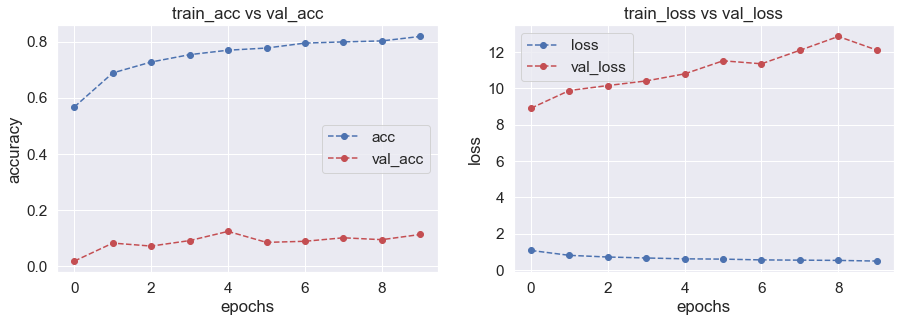

In [36]:
plot_accuracy_loss(history)

In [37]:
# evaluamos la performance del modelo en el test

test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 1s 11ms/step - loss: 2.7897 - accuracy: 0.6693


In [38]:
test_loss

[2.789717435836792, 0.6693333387374878]

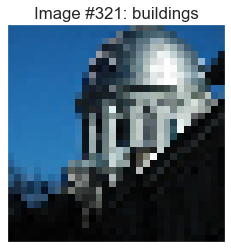

In [39]:
predictions = model.predict(test_images) # vector de probabilidades
pred_labels = np.argmax(predictions, axis=1) # nos quedamoscon la probabilidad más alta

display_random_image(class_names, test_images, pred_labels)

In [44]:
# análisis del error
def print_mislabeled_images (class_names, test_images, test_labels, pred_labels):
    """
    Print 25 examples of mislabeled images by the classifier,
    when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]
    
    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names, mislabeled_images, mislabeled_labels)
    

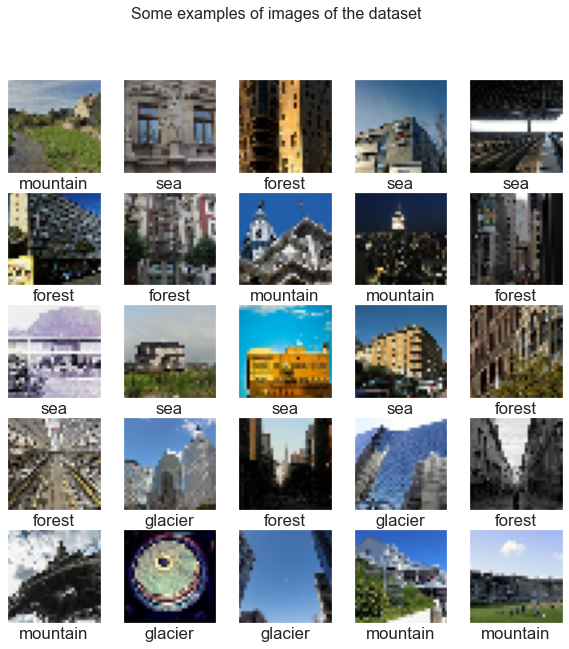

In [45]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)